In [1]:
%matplotlib inline
import pystan
import numpy as np
import matplotlib.pyplot as plt

import sys
import math
import random
import numpy as np
from scipy.io import loadmat

import plotly.offline as pyo
import plotly.graph_objs as go

pyo.init_notebook_mode(connected=True)

In [223]:
# List of timestep sizes
ALLDELTA = range(100)
# Fontsize parameter for plotting
FS = 28

# Dataset
NETDIR = 'primaryschool.csv'
# ID file
IDDIR = 'id_class_gender'

# Import data
ndat = open(NETDIR, 'r').readlines()
ndat = np.asarray([np.asarray([elem for elem in line.strip().split('\t')[:-2]]+line.strip().split('\t')[-2:]) for line in ndat])

# Get all time points
all_t = np.asarray([int(elem) for elem in ndat[:,0]])
# Zero time points
all_t -= min(all_t)
min_t = min(all_t)
max_t = max(all_t)
assert(min_t==0)

# Get all node ID's
all_n = list(set([elem for elem in ndat[:,1]]+[elem for elem in ndat[:,2]]))
# Get all class ID's
all_d = list(set([elem for elem in ndat[:,3]]+[elem for elem in ndat[:,4]]))
nnodes = len(all_n)
ndept = len(all_d)

all_nodes = []
for delta in ALLDELTA:
    
    curr_ndat = np.copy(ndat)
    curr_max_t = max_t
    curr_all_t = np.copy(all_t)
    
    # Coarse-grain time resolution
    # Units of time steps are seconds
    # Time steps are given in 20 second chunks
    curr_all_t //= 60*(delta+1)
    curr_max_t //= 60*(delta+1)
    max_min_diff = []

    all_A_d = []
    
    for ts in range(curr_max_t):

        curr_filt_ts = curr_all_t==ts

        ccurr_ndat = curr_ndat[curr_filt_ts]
        if len(ccurr_ndat.shape)<2:
            ccurr_ndat = np.asarray([ccurr_ndat])
        assert(len(ccurr_ndat.shape)==2)

        # Compute adjacency matrix of interactions that take place during time ts
        A_d = np.zeros((ndept+1,ndept+1), dtype=float)
        
        for row in ccurr_ndat:
            
            nrind1, nrind2 = all_n.index(row[1]), all_n.index(row[2])
            drind1, drind2 = all_d.index(row[3]), all_d.index(row[4])
            
            A_d[drind1][drind2] += 1.
            if drind1 != drind2:
                A_d[drind2][drind1] = A_d[drind1][drind2]
            
        all_A_d.append(A_d.flatten())
    all_A_d = np.asarray(all_A_d).reshape((len(all_A_d),12,12)).astype(int)
    all_nodes.append(all_A_d)

In [30]:
function_code = """
functions {
    
    matrix left_rotation(matrix A, real angle, int n, int p, int i, int j) {
        matrix[n, p] RA;
        RA = A;
        
        RA[i,] = cos(angle)*A[i,] - sin(angle)*A[j,];
        RA[j,] = sin(angle)*A[i,] + cos(angle)*A[j,];
        
        return RA;
    }
    
    matrix right_rotation(matrix A, real angle, int n, int i, int j) {
        matrix[n, n] AR;
        AR = A;
        
        AR[,i] = cos(angle)*A[,i] + sin(angle)*A[,j];
        AR[,j] = -sin(angle)*A[,i] + cos(angle)*A[,j];
        
        return AR;
    }
    
    matrix d_rotation_matrix(real angle, int n, int i, int j) {
        matrix[n, n] dR = diag_matrix(rep_vector(0, n));
        
        dR[i, i] = -sin(angle);
        dR[i, j] = -cos(angle);
        dR[j, i] = cos(angle);
        dR[j, j] = -sin(angle);
        
        return dR;
    }
    
    matrix[] generate_forward_pgivens(vector angles, int n, int p) {
        int d = n*p - p*(p+1)/2;
        int idx;
        matrix[n, n] G;
        matrix[n, n] partial_givens[d+1];
        matrix[n, n] R;
        int pp;
        if(p == n) pp = p - 1;
        else pp = p;
        
        G = diag_matrix(rep_vector(1, n));
        idx = 1;
        partial_givens[1] = G;
        for(i in 1:pp){
            for(j in i+1:n){
                G = right_rotation(G, angles[idx], n, i, j);
                partial_givens[idx + 1] = G;
                idx = idx + 1;
            }
        }
        
        return partial_givens;      
    }
    
    matrix[] generate_reverse_pgivens(vector angles, int n, int p) {
        int d = n*p - p*(p+1)/2;
        int idx;
        matrix[n, n] G_eye;
        matrix[n, p] G;
        matrix[n, p] partial_givens[d+1];
        matrix[n, n] R;
        int pp;
        if(p == n) pp = p - 1;
        else pp = p;

        G_eye = diag_matrix(rep_vector(1, n));
        G = G_eye[,1:p];
        
        partial_givens[d+1] = G;
        idx = d;
        for(i in 1:pp){
            int i_st = pp - i + 1;
            for(j in i_st+1:n){
                G = left_rotation(G, angles[idx], n, p, i_st, n - j + i_st + 1);
                partial_givens[idx] = G;
                idx = idx - 1;
            }
        }
        
        return partial_givens;      
    }
    
    matrix[] generate_givens_jacobians(matrix[] partial_givens_forward, matrix[] partial_givens_reverse, vector angles, int n, int p) {
        int d = n*p - p*(p+1)/2;
        matrix[n,p] derivative_list[d];
        matrix[n,d] givens_jacobian[p];
        int idx = 1;
        int pp;
        if(p == n) pp = p - 1;
        else pp = p;
        
        for(i in 1:p){
            for(j in i+1:n){
                matrix[n,n] dR = d_rotation_matrix(angles[idx], n, i, j);
                matrix[n,n] a = partial_givens_forward[idx];
                matrix[n,p] b = partial_givens_reverse[idx + 1];
                
                derivative_list[idx] = a * dR * b;
                idx = idx + 1;
            }
        }
        
        for(i in 1:pp) {
            for(j in 1:d) {
                vector[n] t = derivative_list[j][,i];
                matrix[n,d] z = givens_jacobian[i];
                z[,j] = t;
                givens_jacobian[i] = z;
            }
        }
        
        return givens_jacobian;
        
    }
    
    matrix area_form_lp(vector angles, int n, int p) {
        int d = n*p - p*(p+1)/2;
        int idx;
        matrix[n, n] givens;
        matrix[n, n] partial_givens_forward[d+1];
        matrix[n, p] partial_givens_reverse[d+1];
        matrix[n, d] givens_jacobians[p];
        matrix[d, d] area_mat;
        int pp;
        if(p == n) pp = p - 1;
        else pp = p;
        

        partial_givens_forward = generate_forward_pgivens(angles, n, p);
        partial_givens_reverse = generate_reverse_pgivens(angles, n, p);
        givens = partial_givens_forward[d+1];
        
        givens_jacobians = generate_givens_jacobians(partial_givens_forward, partial_givens_reverse, angles, n, p);
        
        idx = 1;
        for(i in 1:pp){
            matrix[d, n-i] one_forms;
            one_forms = (givens'[i+1:n,] * givens_jacobians[i])';
            for(j in 1:n-i) {
                area_mat[,idx] = one_forms[,j]; 
                idx = idx + 1;
            }
        }
        
        target += log_determinant(area_mat); 
        return givens[,1:p];
    }
    
    matrix area_form(vector angles, int n, int p) {
        int d = n*p - p*(p+1)/2;
        int idx;
        matrix[n, n] givens;
        matrix[n, n] partial_givens_forward[d+1];
        matrix[n, p] partial_givens_reverse[d+1];
        matrix[n, d] givens_jacobians[p];
        matrix[d, d] area_mat;
        int pp;
        if(p == n) pp = p - 1;
        else pp = p;
        

        partial_givens_forward = generate_forward_pgivens(angles, n, p);
        partial_givens_reverse = generate_reverse_pgivens(angles, n, p);
        givens = partial_givens_forward[d+1];
        
        givens_jacobians = generate_givens_jacobians(partial_givens_forward, partial_givens_reverse, angles, n, p);
        
        idx = 1;
        for(i in 1:pp){
            matrix[d, n-i] one_forms;
            one_forms = (givens'[i+1:n,] * givens_jacobians[i])';
            for(j in 1:n-i) {
                area_mat[,idx] = one_forms[,j]; 
                idx = idx + 1;
            }
        }
    
        return givens[,1:p];
    }
}

data {
    int n;
    int p;
    int d;
    int N; // number of data points
    
    int<lower=1> K; // num categories
    int<lower=0> interactions[N,n,n];
}

transformed data {
}

parameters {
    simplex[K] phi[K]; //transit probs
    vector<lower = -pi()/2, upper = pi()/2>[d] theta[K]; // emission parameters
    vector[p] Lambda[K];
    vector<lower=0>[K] beta;
}

transformed parameters{
    matrix[n, n] Ws[K];
    matrix[n, p] Wt[K];
    
    for (k in 1:K) {
        matrix[p, p] diag_l;
        diag_l = diag_matrix(Lambda[k]);
        Wt[k] = area_form_lp(theta[k], n, p);
        Ws[k] = Wt[k] * diag_l * Wt[k]';
    }
}

model {
    real acc[K];
    real gamma[N, K];
    
    for (k in 1:K)
        phi[k] ~ dirichlet(beta);
    
    // compute jacobian correction for area representation
    // and combined matrix
    for (k in 1:K) {
        gamma[1,k] = 0;
        for(x in 1:n) {
            for(y in x:n) {
                gamma[1,k] = gamma[1,k] + poisson_log(interactions[1,x,y], exp(Ws[k][x,y]));
            }
        }
    }
    
    // forwards algorithm to compute likelihood
    for (t in 2:N) {
        for (k in 1:K) {
            for (j in 1:K) {
                acc[j] = gamma[t-1,j] + log(phi[j,k]);
                for(x in 1:n) {
                    for(y in x:n) {
                        acc[j] = acc[j] + poisson_log(interactions[t,x,y], exp(Ws[k][x,y]));
                    }
                }
            }
            gamma[t,k] = log_sum_exp(acc);
        }
    }
    
    // accumulate likelihood
    target += log_sum_exp(gamma[N]);
}

generated quantities {
    int<lower=1, upper=K> y_star[N];
    real log_p_y_star;
    {
        int back_ptr[N, K];
        real best_logp[N, K];
        for (k in 1:K) {
            best_logp[1,k] = 0;
            for(x in 1:n) {
                for(y in x:n) {
                    best_logp[1,k] = best_logp[1,k] + poisson_log(interactions[1,x,y], exp(Ws[k][x,y]));
                }
            }
        }
    
        for (t in 2:N) {
            for (k in 1:K) {
                best_logp[t,k] = negative_infinity();
                for(j in 1:K) {
                    real logp;
                    logp = best_logp[t-1,j] + log(phi[j,k]);
                    for(x in 1:n) {
                        for(y in x:n) {
                            logp = logp + poisson_log(interactions[t,x,y], exp(Ws[k][x,y]));
                        }
                    }
                    if (logp > best_logp[t,k]) {
                        back_ptr[t,k] = j;
                        best_logp[t,k] = logp;
                    }

                }
            }
        }

        log_p_y_star = max(best_logp[N]);
        for(k in 1:K) {
            if(best_logp[N,k] == log_p_y_star) {
                y_star[N] = k;
            }
        }

        for(t in 1:(N-1)){
            y_star[N - t] = back_ptr[N - t + 1, y_star[N - t + 1]];
        }
    } 
}
"""

In [31]:
sm_infer = pystan.StanModel(model_code=function_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7864d9641753a0c0103111a283a4eb47 NOW.


In [38]:
n = 12
p = 2
d = int(n * p - p*(p+1)/2)
K = 3
all_nodes_dat = all_nodes[10]

iters_infer = 5000
data_infer = {'n' : n, 'p' : p, 'd' : d, 'K': K, 'N' : all_nodes_dat.shape[0], 'interactions' : all_nodes_dat, 'beta' : [1/K for _ in range(K)]}
fit_infer = sm_infer.sampling(data = data_infer, iter = iters_infer, chains = 1)
#fit_vi = sm_infer.vb(data=data_infer)

In [226]:
angles = fit_infer.extract()['theta']
transprobs = fit_infer.extract()['phi']
y_star = fit_infer.extract()['y_star']
Ws = fit_infer.extract()['Ws']
Wt = fit_infer.extract()['Wt']
Lambda = fit_infer.extract()['Lambda']
all_nodes_dat = all_nodes[10]

In [40]:
print(fit_infer)

Inference for Stan model: anon_model_7864d9641753a0c0103111a283a4eb47.
1 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=2500.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
phi[0,0]       0.97  2.9e-3   0.02   0.93   0.96   0.98   0.98   0.99     33   1.07
phi[1,0]       0.13  7.8e-3   0.09   0.01   0.07   0.12   0.17   0.34    119   1.01
phi[2,0]       0.02  1.8e-3   0.02 2.3e-3 9.8e-3   0.02   0.03   0.07     90   1.03
phi[0,1]       0.02  2.9e-3   0.02 4.6e-3   0.01   0.02   0.03   0.07     32   1.07
phi[1,1]       0.75    0.02   0.12   0.48   0.67   0.76   0.85   0.94     50   1.03
phi[2,1]     3.6e-3  3.6e-4 7.1e-36.0e-11 1.4e-5 5.6e-4 3.6e-3   0.02    382    1.0
phi[0,2]     3.8e-3  3.6e-4 6.0e-3 2.4e-9 9.8e-5 1.3e-3 5.1e-3   0.02    287    1.0
phi[1,2]       0.12    0.01   0.09 2.1e-3   0.04   0.11   0.18   0.32     61   1.02
phi[2,2]       0.98  1.9e-3   0.02   0.92   0.97   0.98

In [115]:
print(Ws.shape)
hist1 = go.Histogram(x = Ws[:,0, 0, 1])
hist2 = go.Histogram(x = Ws[:,1, 0, 1])
hist3 = go.Histogram(x = Ws[:,2, 0, 1])
pyo.iplot([hist3])

(2500, 3, 12, 12)


In [61]:
hist1 = go.Scatter(x = list(range(angles.shape[0])), y=angles[:,0,15])
#hist1 = go.Histogram(x = angles[:,0,5])
pyo.iplot([hist1])

In [142]:
hist1 = go.Histogram(x = transprobs[:,2,0])
hist2 = go.Histogram(x = transprobs[:,2,1])
hist3 = go.Histogram(x = transprobs[:,2,2])
pyo.iplot([hist1, hist2, hist3])


In [166]:
import pandas as pd

transprobs_resh = pd.DataFrame(transprobs.reshape((transprobs.shape[0], transprobs.shape[1] * transprobs.shape[2])))
Ws_resh_0 = pd.DataFrame(Ws[:,0,0,:].reshape((Ws.shape[0], Ws.shape[3])))
Ws_resh_1 = pd.DataFrame(Ws[:,1,0,:].reshape((Ws.shape[0], Ws.shape[3])))
Ws_resh_2 = pd.DataFrame(Ws[:,2,0,:].reshape((Ws.shape[0], Ws.shape[3])))

transprobs_resh.to_csv('transprobs.csv', header = None, index = None)
Ws_resh_0.to_csv('Ws0.csv', header = None, index = None)
Ws_resh_1.to_csv('Ws1.csv', header = None, index = None)
Ws_resh_2.to_csv('Ws2.csv', header = None, index = None)

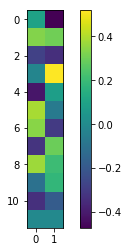

In [141]:
plt.imshow(Wt[1000,0,:,:])
plt.colorbar()

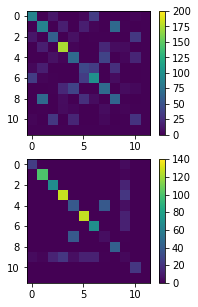

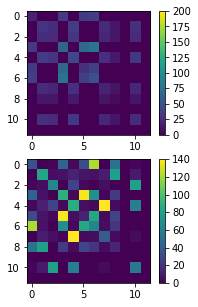

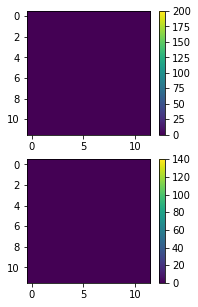

In [260]:
# 2, 23, 109
fig, axes = plt.subplots(nrows = 2, ncols = 1)
im0 = axes[0].imshow(np.mean(np.exp(Ws[:,0,:,:]), axis = 0), vmin = 0, vmax = 200)
im1 = axes[1].imshow(all_nodes_dat[2], vmin = 0, vmax = 140)
fig.colorbar(im0, ax = axes[0])
fig.colorbar(im1, ax = axes[1])
fig.set_size_inches(6, 10)
plt.savefig('0_combined.svg')
plt.show()

fig, axes = plt.subplots(nrows = 2, ncols = 1)
im0 = axes[0].imshow(np.mean(np.exp(Ws[:,1,:,:]), axis = 0), vmin = 0, vmax = 200)
im1 = axes[1].imshow(all_nodes_dat[23], vmin = 0, vmax = 140)
fig.colorbar(im0, ax = axes[0])
fig.colorbar(im1, ax = axes[1])
fig.set_size_inches(6, 10)
plt.savefig('1_combined.svg')
plt.show()

fig, axes = plt.subplots(nrows = 2, ncols = 1)
im0 = axes[0].imshow(np.mean(np.exp(Ws[:,2,:,:]), axis = 0), vmin = 0, vmax = 200)
im1 = axes[1].imshow(all_nodes_dat[109], vmin = 0, vmax = 140)
fig.colorbar(im0, ax = axes[0])
fig.colorbar(im1, ax = axes[1])
fig.set_size_inches(6, 10)
plt.savefig('2_combined.svg')
plt.show()

In [94]:
print(all_nodes_dat.shape)

(177, 12, 12)


In [93]:
import pickle
with open('fit.pkl', 'wb') as f:
    pickle.dump(fit_infer.extract(), f)

To demonstrate the extensibility of our technique beyond normality and dimensionality reduction applications, we try our method on a non-PPCA based example that depends on an orthonormal decomposition and obtain uncertainty estimates over the resulting matrices.

The school interaction dataset is a list of the interactions between different classes at a single school over the course of 2 days.  Face-to-face interactions of students between and within different classes were recorded every 20 seconds throughout the 2 days, capturing the change in interaction dynamics as students transition from class to recess and ultimately to home.  The resulting data was binned together into 177 equally spaced time intervals and formed into an adjacency matrix for the number of interaction between classes at each interval.

To analyze the properties of the different states in this data, we fit a Hidden Markov Model with the emission at each state for each class dependent on a Poisson random variable, with rate specified by an orthonormal decomposition of a rate matrix.  A graphical model of this is shown in Figure.  Specifically, this forms the following generative process:

$$
\begin{align}
    \pi_k &\sim& Dirichlet(\beta) \\
    z_t | z_{t-1}, \mathbf{\pi} &\sim& Categorical(\pi_{z_{t-1}}) \\
    \theta_k &\sim& GT(n,p) \\
    W_k &=& IGT(\theta_k) \\
    \Lambda_k &\sim& Uniform() \\
    X_{t,i,j} | z_t, W_{z_t} &\sim& Poisson(exp(W_{z_t} \Lambda_{z_t} W_{z_t}^T)_{i,j})
\end{align}
$$

In figure, we show the rate matrices captured from the fit and the posteriors for each entry.  It can be seen that the the matrices are significantly different from each other, in general each capturing a different dynamic as expected.  In state 0, interaction is dominated mainly on the diagonals where classes socialize with each other.  State 1 corresponds to the case where interaction is more spread out, likely due to lunch or outside activities.  State 2 is nearly all 0, corresponding to students going home and no interaction occuring.  
